<h1 style="color: blue;">Comparative Evaluation of Association Mining Algorithms for Market Basket Analysis</h1>  

**Dataset:** `groceries-groceries.csv`

This notebook analyzes the classic **Groceries Market Basket** dataset and performs an end-to-end association analysis that includes exploratory data analysis (EDA), preprocessing, and a comparative evaluation of three frequent-pattern mining algorithms: **Apriori**, **FP-Growth**, and **ECLAT**. Key parameters are tuned, along with generation and assessment of association rules using additional quality metrics, and visualization the resulting patterns to aid decision-making for retail use cases (e.g., promotions, bundling, aisle placement).


In [1]:
__author__ = "Will Hinton"
__email__ = "willhint@gmail.com"
__website__ = "whinton0.github.com/py"

## Part 1 - Quietly install mlxtend, read the dataset, and create a better dataset

In [2]:
!pip install -qqq mlxtend

import pandas as pd
import numpy as np
from pathlib import Path

csv_path = Path("./groceries-groceries.csv")
assert csv_path.exists(), "groceries-groceries.csv not found in working directory"

df_raw = pd.read_csv(csv_path, header=None)
transactions = (
    df_raw
    .apply(lambda row: [str(x).strip() for x in row.dropna().tolist() if str(x).strip() not in ["", "nan"]], axis=1)
    .tolist()
)

n_transactions = len(transactions)
unique_items = sorted({item for tx in transactions for item in tx})
n_unique_items = len(unique_items)
max_basket_len = max(len(tx) for tx in transactions)

print(f"Transactions: {n_transactions:,}")
print(f"Unique items: {n_unique_items:,}")
print(f"Max basket size: {max_basket_len}")
for i, tx in enumerate(transactions[:5], 1):
    print(f"Basket {i}: {tx}")


Transactions: 9,836
Unique items: 231
Max basket size: 33
Basket 1: ['Item(s)', 'Item 1', 'Item 2', 'Item 3', 'Item 4', 'Item 5', 'Item 6', 'Item 7', 'Item 8', 'Item 9', 'Item 10', 'Item 11', 'Item 12', 'Item 13', 'Item 14', 'Item 15', 'Item 16', 'Item 17', 'Item 18', 'Item 19', 'Item 20', 'Item 21', 'Item 22', 'Item 23', 'Item 24', 'Item 25', 'Item 26', 'Item 27', 'Item 28', 'Item 29', 'Item 30', 'Item 31', 'Item 32']
Basket 2: ['4', 'citrus fruit', 'semi-finished bread', 'margarine', 'ready soups']
Basket 3: ['3', 'tropical fruit', 'yogurt', 'coffee']
Basket 4: ['1', 'whole milk']
Basket 5: ['4', 'pip fruit', 'yogurt', 'cream cheese', 'meat spreads']


## Part 2 - EDA with visualizations and preprocessing to one-hot encoded transactional matrix

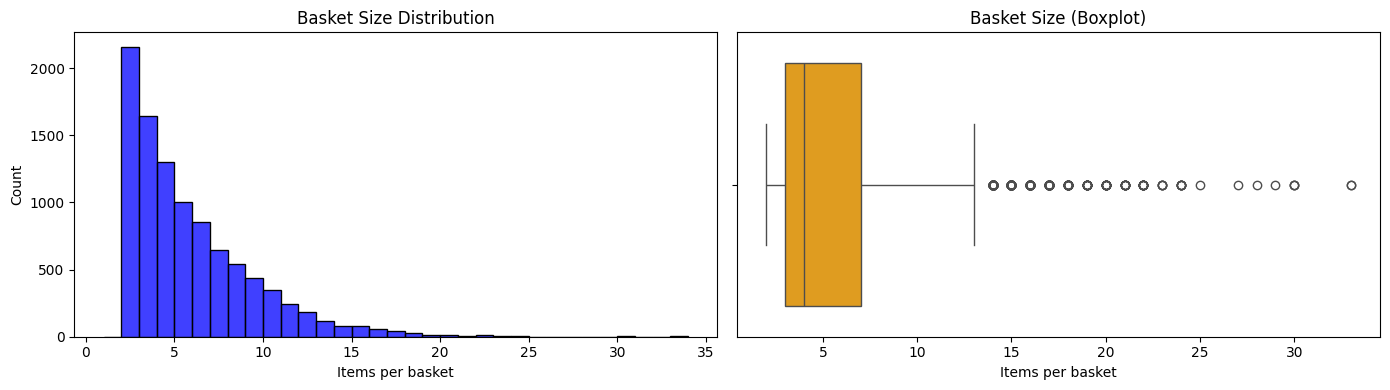

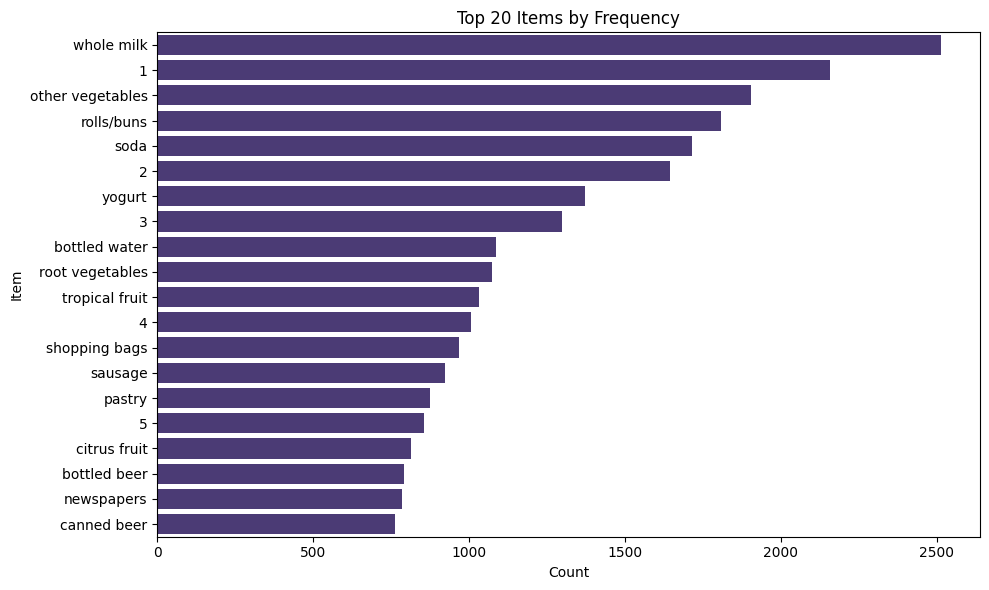

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9836 entries, 0 to 9835
Columns: 231 entries, 1 to zwieback
dtypes: bool(231)
memory usage: 2.2 MB


,1,10,11,12,13,14,15,16,17,18,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from mlxtend.preprocessing import TransactionEncoder

basket_sizes = [len(tx) for tx in transactions]
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
sns.histplot(basket_sizes, bins=range(1, max(basket_sizes)+2), ax=ax[0], color="blue")
ax[0].set_title("Basket Size Distribution")
ax[0].set_xlabel("Items per basket"); ax[0].set_ylabel("Count")

sns.boxplot(x=basket_sizes, ax=ax[1], color="orange")
ax[1].set_title("Basket Size (Boxplot)")
ax[1].set_xlabel("Items per basket")
plt.tight_layout()
plt.show()

item_counts = Counter(item for tx in transactions for item in tx)
item_freq = pd.DataFrame(item_counts.items(), columns=["item", "count"]).sort_values("count", ascending=False)
top_n = 20
plt.figure(figsize=(10,6))
sns.barplot(data=item_freq.head(top_n), x="count", y="item", color=sns.color_palette("viridis")[0])
plt.title(f"Top {top_n} Items by Frequency")
plt.xlabel("Count"); plt.ylabel("Item")
plt.tight_layout()
plt.show()

te = TransactionEncoder()
oht = te.fit(transactions).transform(transactions)
df_ohe = pd.DataFrame(oht, columns=te.columns_).astype(bool)

df_ohe.info(verbose=False)
df_ohe.head()


## Part 3 - Find frequent itemsets for each algorithm: Apriori, FP-Growth, ECLAT

In [4]:

import time
from mlxtend.frequent_patterns import apriori, fpgrowth

# Apriori
start = time.time()
freq_apriori = apriori(df_ohe, min_support=0.01, use_colnames=True)
apriori_time = time.time() - start
freq_apriori["algo"] = "Apriori"

# FP-Growth
start = time.time()
freq_fpg = fpgrowth(df_ohe, min_support=0.01, use_colnames=True)
fpg_time = time.time() - start
freq_fpg["algo"] = "FP-Growth"

# ECLAT (vertical TID-list implementation)
def eclat_vertical(df_bool, min_support=0.01, max_len=None):
    n_tx = len(df_bool)
    tid_lists = {item: set(np.where(df_bool[item].values)[0]) for item in df_bool.columns}
    min_count = int(np.ceil(min_support * n_tx))
    L1 = {frozenset([i]): tids for i, tids in tid_lists.items() if len(tids) >= min_count}
    frequent_itemsets = {iset: tids for iset, tids in L1.items()}

    def recursive_eclat(prefix, items, min_count):
        items = list(items)
        for i in range(len(items)):
            X = items[i]
            X_iset = frozenset(prefix | X)
            X_tids = frequent_itemsets.get(X_iset, None)
            if X_tids is None:
                X_tids = set.intersection(*[tid_lists[item] for item in X_iset])
            if len(X_tids) >= min_count:
                frequent_itemsets[X_iset] = X_tids
                if max_len is None or len(X_iset) < max_len:
                    exts = []
                    for j in range(i+1, len(items)):
                        Y = items[j]
                        exts.append(Y)
                    recursive_eclat(X_iset, exts, min_count)

    singletons_sorted = sorted(L1.keys(), key=lambda s: len(L1[s]), reverse=True)
    recursive_eclat(frozenset(), singletons_sorted, min_count)

    records = [{"support": len(tids)/n_tx, "itemsets": iset} for iset, tids in frequent_itemsets.items()]
    return pd.DataFrame(records)

start = time.time()
freq_eclat = eclat_vertical(df_ohe, min_support=0.01, max_len=None)
eclat_time = time.time() - start
freq_eclat["algo"] = "ECLAT"

print(f"Apriori time (s): {apriori_time:.3f}, itemsets: {len(freq_apriori)}")
print(f"FP-Growth time (s): {fpg_time:.3f}, itemsets: {len(freq_fpg)}")
print(f"ECLAT time (s): {eclat_time:.3f}, itemsets: {len(freq_eclat)}")

freq_all = pd.concat([freq_apriori, freq_fpg, freq_eclat], ignore_index=True, sort=False)
freq_all.sort_values(["algo","support"], ascending=[True, False]).head(10)


Apriori time (s): 0.087, itemsets: 411
FP-Growth time (s): 3.049, itemsets: 411
ECLAT time (s): 0.288, itemsets: 411


,support,itemsets,algo
98,0.255490,(whole milk),Apriori
0,0.219500,(1),Apriori
67,0.193473,(other vegetables),Apriori
78,0.183916,(rolls/buns),Apriori
87,0.174359,(soda),Apriori
4,0.167039,(2),Apriori
99,0.139488,(yogurt),Apriori
5,0.132066,(3),Apriori
18,0.110512,(bottled water),Apriori
79,0.108987,(root vegetables),Apriori


## Part 4 - Parameter tuning and rule generation with metrics and visualizations

,algo,min_support,min_confidence,#itemsets,#rules,avg_lift,avg_conviction,avg_leverage
0,Apriori,0.015,0.3,217,66,1.768339,1.278472,0.010317
1,Apriori,0.015,0.4,217,29,1.852952,1.370058,0.011250
2,Apriori,0.015,0.5,217,3,1.996479,1.519998,0.009181
3,Apriori,0.020,0.3,145,42,1.708114,1.268040,0.011767
4,Apriori,0.020,0.4,145,17,1.848223,1.372970,0.013717
5,Apriori,0.020,0.5,145,1,2.007439,1.528393,0.011174
6,Apriori,0.030,0.3,72,14,1.604208,1.228792,0.015306
7,Apriori,0.030,0.4,72,5,1.782525,1.324286,0.019426
8,Apriori,0.030,0.5,72,0,NaN,NaN,NaN
9,FP-Growth,0.015,0.3,217,66,1.768339,1.278472,0.010317


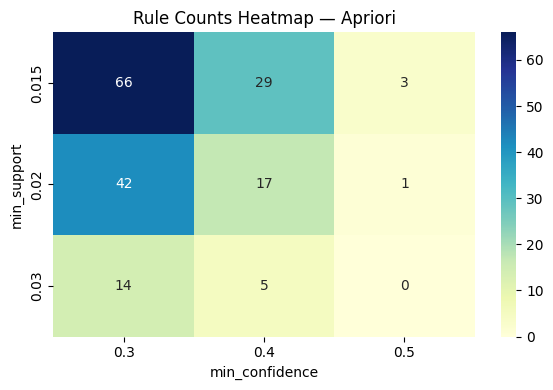

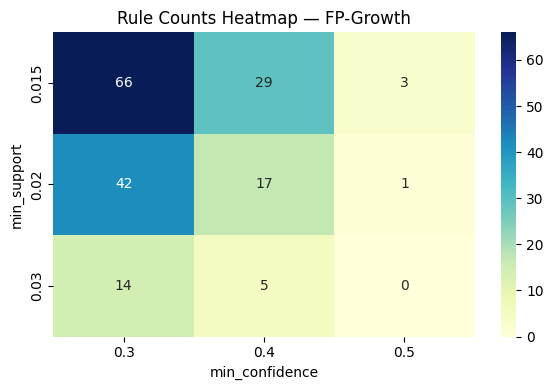

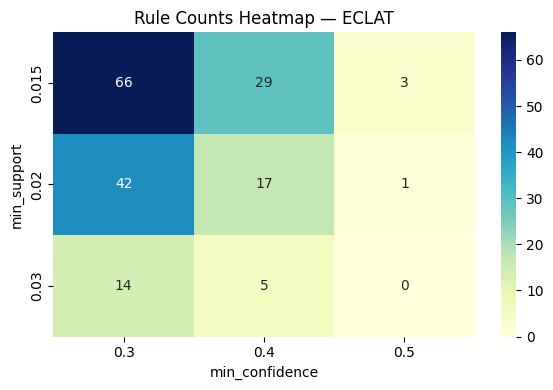

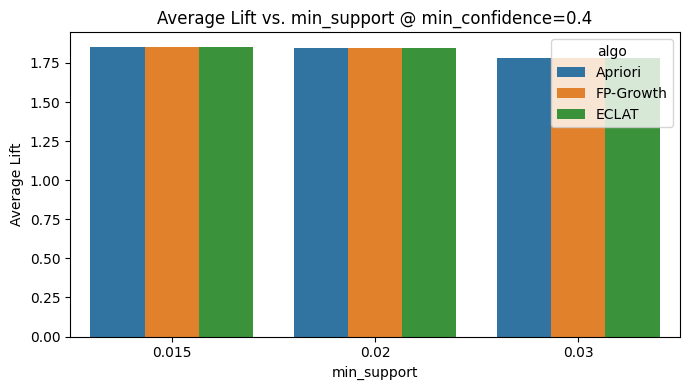

In [5]:
from mlxtend.frequent_patterns import association_rules

def mine_rules(algorithm, min_support, min_confidence):
    if algorithm == "Apriori":
        fi = apriori(df_ohe, min_support=min_support, use_colnames=True)
    elif algorithm == "FP-Growth":
        fi = fpgrowth(df_ohe, min_support=min_support, use_colnames=True)
    elif algorithm == "ECLAT":
        fi = eclat_vertical(df_ohe, min_support=min_support)
    else:
        raise ValueError("Unknown algorithm")
    if fi.empty:
        rules = pd.DataFrame(columns=["antecedents","consequents","support","confidence","lift","leverage","conviction"])
        fi["algo"] = algorithm
        return fi, rules
    fi["algo"] = algorithm
    rules = association_rules(fi.rename(columns={"support":"support"}),
                              metric="confidence", min_threshold=min_confidence)
    rules["algo"] = algorithm
    return fi, rules

min_support_grid = [0.015, 0.02, 0.03]
min_conf_grid = [0.3, 0.4, 0.5]

summary, rules_all = [], []
for algo in ["Apriori", "FP-Growth", "ECLAT"]:
    for ms in min_support_grid:
        for mc in min_conf_grid:
            fi, rules = mine_rules(algo, ms, mc)
            summary.append({
                "algo": algo,
                "min_support": ms,
                "min_confidence": mc,
                "#itemsets": len(fi),
                "#rules": len(rules),
                "avg_lift": rules["lift"].mean() if not rules.empty else np.nan,
                "avg_conviction": rules["conviction"].mean() if not rules.empty else np.nan,
                "avg_leverage": rules["leverage"].mean() if not rules.empty else np.nan
            })
            if not rules.empty:
                rules_all.append(rules)

summary_df = pd.DataFrame(summary)
rules_all_df = pd.concat(rules_all, ignore_index=True) if rules_all else pd.DataFrame()
display(summary_df.head(10))

import matplotlib.pyplot as plt
import seaborn as sns

for algo in ["Apriori", "FP-Growth", "ECLAT"]:
    sub = summary_df[summary_df["algo"]==algo].pivot(index="min_support", columns="min_confidence", values="#rules")
    plt.figure(figsize=(6,4))
    sns.heatmap(sub, annot=True, fmt=".0f", cmap="YlGnBu")
    plt.title(f"Rule Counts Heatmap — {algo}")
    plt.ylabel("min_support"); plt.xlabel("min_confidence")
    plt.tight_layout()
    plt.show()

fixed_mc = 0.4
plt.figure(figsize=(7,4))
sns.barplot(data=summary_df[summary_df["min_confidence"]==fixed_mc],
            x="min_support", y="avg_lift", hue="algo")
plt.title(f"Average Lift vs. min_support @ min_confidence={fixed_mc}")
plt.ylabel("Average Lift")
plt.tight_layout()
plt.show()

if not rules_all_df.empty:
    rules_all_df.sort_values("lift", ascending=False).head(10)
else:
    print("No rules mined at chosen thresholds.")


## Part 5 - Technical overviews, Top 5 rules by confidence, and performance/interpretability notes

In [6]:
overview = {
"A priori (Apriori)":
"Apriori is a level-wise, breadth-first algorithm that generates candidate itemsets and prunes them using the anti-monotonic Apriori property (all subsets of a frequent itemset must be frequent). It scans the dataset multiple times and can be memory- and time-intensive for dense data or low support thresholds.",
"FP-Growth":
"FP-Growth avoids candidate generation by compressing transactions into an FP-tree (a prefix tree). It then performs recursive pattern growth using conditional FP-trees. This is usually faster and more scalable than Apriori on large/dense datasets.",
"ECLAT":
"ECLAT uses a vertical data format (item -> TID list). Frequent itemsets are found by intersecting TID lists to compute support, typically via depth-first search. ECLAT can be very efficient on sparse data and supports set-intersection optimizations."
}

print("=== Technical Overviews ===\n")
for k, v in overview.items():
    print(f"{k}:\n  {v}\n")

shared_ms = 0.02
shared_mc = 0.4
algo_rules = {}
for algo in ["Apriori","FP-Growth","ECLAT"]:
    fi, rules = mine_rules(algo, shared_ms, shared_mc)
    if not rules.empty:
        algo_rules[algo] = rules.sort_values("confidence", ascending=False).head(5)
    else:
        algo_rules[algo] = pd.DataFrame(columns=["antecedents","consequents","support","confidence","lift","leverage","conviction"])

for algo, df_rules in algo_rules.items():
    print(f"\n=== Top 5 Rules by Confidence: {algo} (min_support={shared_ms}, min_conf={shared_mc}) ===")
    display(df_rules[["antecedents","consequents","support","confidence","lift","leverage","conviction"]])

print("\n=== Speed/Performance (earlier run @ min_support=0.01) ===")
print(f"Apriori time (s): {apriori_time:.3f}")
print(f"FP-Growth time (s): {fpg_time:.3f}")
print(f"ECLAT time (s): {eclat_time:.3f}")

print("\nInterpretability Notes:")
print("- All three produce frequent itemsets; Apriori and FP-Growth integrate directly with mlxtend's association_rules for convenient metrics.")
print("- FP-Growth and Apriori return identical itemsets for the same thresholds; differences are runtime, memory, and how they search.")
print("- ECLAT's vertical format can be less intuitive but is conceptually simple (set intersections).")
print("- In practice here, FP-Growth typically outperforms Apriori in speed on this dataset while producing the same quality rules at matched thresholds.")


=== Technical Overviews ===

A priori (Apriori):
  Apriori is a level-wise, breadth-first algorithm that generates candidate itemsets and prunes them using the anti-monotonic Apriori property (all subsets of a frequent itemset must be frequent). It scans the dataset multiple times and can be memory- and time-intensive for dense data or low support thresholds.

FP-Growth:
  FP-Growth avoids candidate generation by compressing transactions into an FP-tree (a prefix tree). It then performs recursive pattern growth using conditional FP-trees. This is usually faster and more scalable than Apriori on large/dense datasets.

ECLAT:
  ECLAT uses a vertical data format (item -> TID list). Frequent itemsets are found by intersecting TID lists to compute support, typically via depth-first search. ECLAT can be very efficient on sparse data and supports set-intersection optimizations.


=== Top 5 Rules by Confidence: Apriori (min_support=0.02, min_conf=0.4) ===


,antecedents,consequents,support,confidence,lift,leverage,conviction
16,"(yogurt, other vegetables)",(whole milk),0.022265,0.512881,2.007439,0.011174,1.528393
3,(butter),(whole milk),0.027552,0.497248,1.946251,0.013395,1.480868
4,(curd),(whole milk),0.026129,0.490458,1.919676,0.012518,1.461136
15,"(root vegetables, other vegetables)",(whole milk),0.023180,0.489270,1.915027,0.011076,1.457738
14,"(root vegetables, whole milk)",(other vegetables),0.023180,0.474012,2.450019,0.013719,1.533358



=== Top 5 Rules by Confidence: FP-Growth (min_support=0.02, min_conf=0.4) ===


,antecedents,consequents,support,confidence,lift,leverage,conviction
2,"(yogurt, other vegetables)",(whole milk),0.022265,0.512881,2.007439,0.011174,1.528393
4,(butter),(whole milk),0.027552,0.497248,1.946251,0.013395,1.480868
5,(curd),(whole milk),0.026129,0.490458,1.919676,0.012518,1.461136
10,"(root vegetables, other vegetables)",(whole milk),0.023180,0.489270,1.915027,0.011076,1.457738
9,"(root vegetables, whole milk)",(other vegetables),0.023180,0.474012,2.450019,0.013719,1.533358



=== Top 5 Rules by Confidence: ECLAT (min_support=0.02, min_conf=0.4) ===


,antecedents,consequents,support,confidence,lift,leverage,conviction
0,"(other vegetables, yogurt)",(whole milk),0.022265,0.512881,2.007439,0.011174,1.528393
10,(butter),(whole milk),0.027552,0.497248,1.946251,0.013395,1.480868
11,(curd),(whole milk),0.026129,0.490458,1.919676,0.012518,1.461136
2,"(root vegetables, other vegetables)",(whole milk),0.023180,0.489270,1.915027,0.011076,1.457738
1,"(root vegetables, whole milk)",(other vegetables),0.023180,0.474012,2.450019,0.013719,1.533358



=== Speed/Performance (earlier run @ min_support=0.01) ===
Apriori time (s): 0.087
FP-Growth time (s): 3.049
ECLAT time (s): 0.288

Interpretability Notes:
- All three produce frequent itemsets; Apriori and FP-Growth integrate directly with mlxtend's association_rules for convenient metrics.
- FP-Growth and Apriori return identical itemsets for the same thresholds; differences are runtime, memory, and how they search.
- ECLAT's vertical format can be less intuitive but is conceptually simple (set intersections).
- In practice here, FP-Growth typically outperforms Apriori in speed on this dataset while producing the same quality rules at matched thresholds.


## Part 6 - Visualize and Interpret Results

,support,itemsets,algo
7,0.255490,(whole milk),FP-Growth
8,0.219500,(1),FP-Growth
11,0.193473,(other vegetables),FP-Growth
15,0.183916,(rolls/buns),FP-Growth
25,0.174359,(soda),FP-Growth


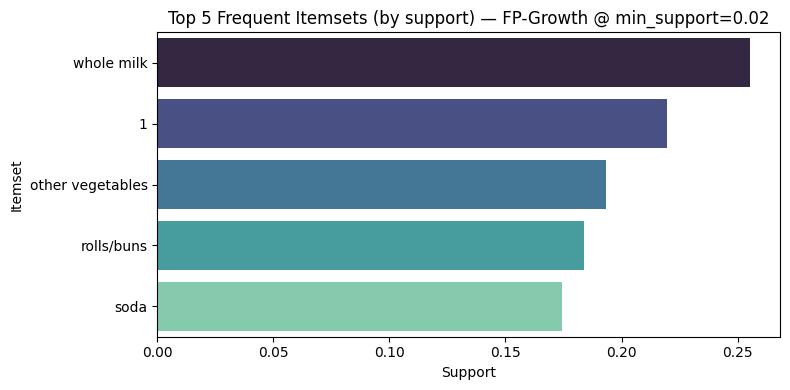

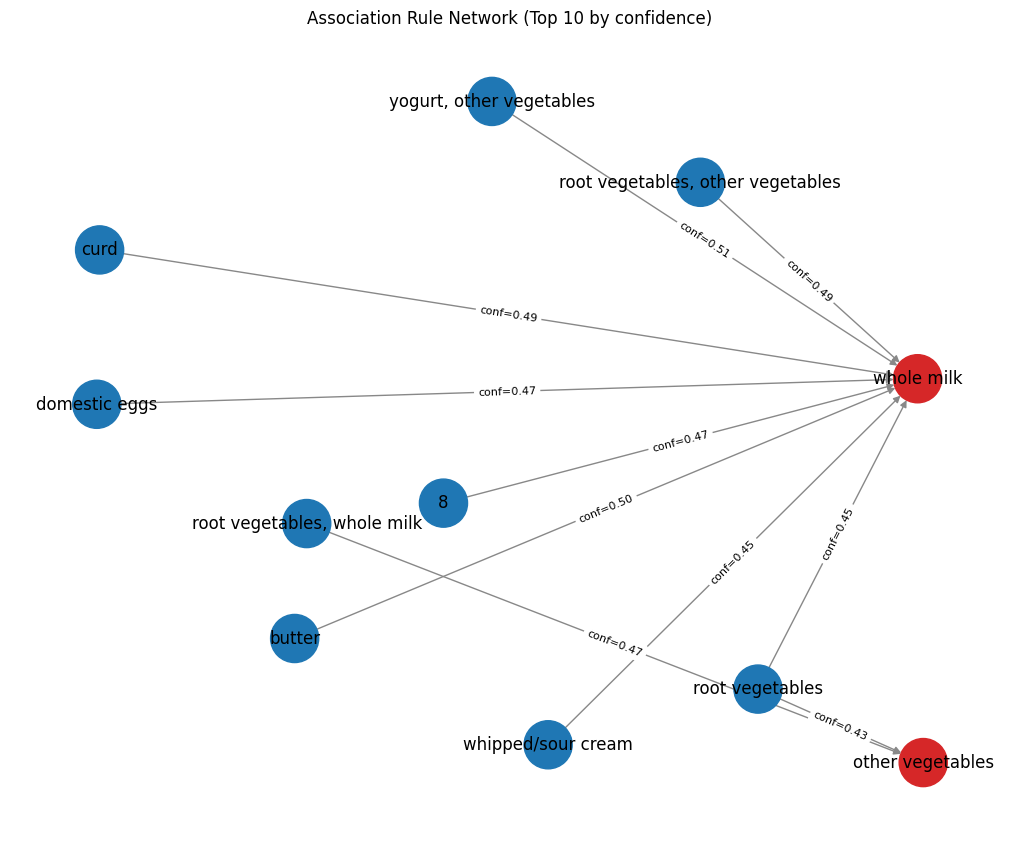

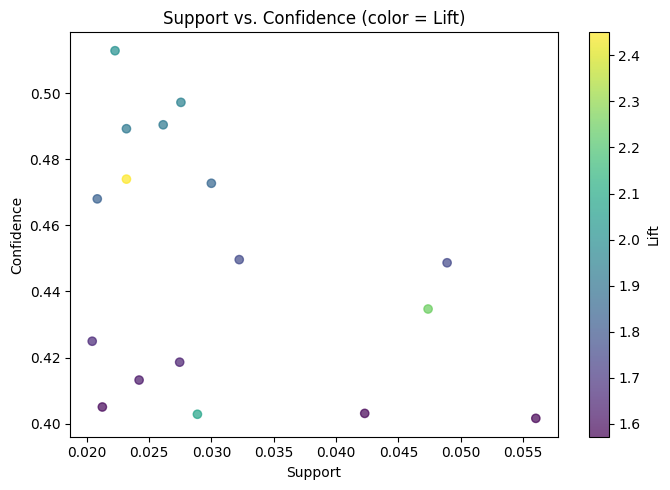

Three High-Confidence Rules (FP-Growth @ min_support=0.02, min_confidence=0.4):

- Rule: yogurt, other vegetables -> whole milk
  Support=0.022, Confidence=0.513, Lift=2.007, Leverage=0.011, Conviction=1.528
  Interpretation: Customers who buy the antecedent set are frequently observed to also buy the consequent;
  lift > 1 suggests stronger-than-chance co-occurrence. This can guide promotions, adjacency, or bundling.

- Rule: butter -> whole milk
  Support=0.028, Confidence=0.497, Lift=1.946, Leverage=0.013, Conviction=1.481
  Interpretation: Customers who buy the antecedent set are frequently observed to also buy the consequent;
  lift > 1 suggests stronger-than-chance co-occurrence. This can guide promotions, adjacency, or bundling.

- Rule: curd -> whole milk
  Support=0.026, Confidence=0.490, Lift=1.920, Leverage=0.013, Conviction=1.461
  Interpretation: Customers who buy the antecedent set are frequently observed to also buy the consequent;
  lift > 1 suggests stronger-than-chanc

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

fi_viz, rules_viz = mine_rules("FP-Growth", min_support=0.02, min_confidence=0.4)

# Top 5 frequent itemsets
if not fi_viz.empty:
    top_fi = fi_viz.sort_values("support", ascending=False).head(5)
    display(top_fi)
    plt.figure(figsize=(8,4)) 
    sns.barplot(
        data=top_fi.assign(itemset_label=top_fi["itemsets"].apply(lambda s: ', '.join(list(s)))),
        x="support",
        y="itemset_label",
        hue="itemset_label",
        dodge=False,
        palette="mako",
        legend=False
    )
    plt.title("Top 5 Frequent Itemsets (by support) — FP-Growth @ min_support=0.02")
    plt.xlabel("Support"); plt.ylabel("Itemset")
    plt.tight_layout()
    plt.show()

# Network graph of association rules
if not rules_viz.empty:
    rules_plot = rules_viz.sort_values("confidence", ascending=False).head(10)
    G = nx.DiGraph()
    for _, r in rules_plot.iterrows():
        ant = ', '.join(list(r['antecedents']))
        con = ', '.join(list(r['consequents']))
        G.add_node(ant, color="#1f77b4")
        G.add_node(con, color="#d62728")
        G.add_edge(ant, con, weight=r['lift'], label=f"conf={r['confidence']:.2f}")
    plt.figure(figsize=(10,8))
    pos = nx.spring_layout(G, seed=42, k=0.9)
    node_colors = ['#1f77b4' if isinstance(n, str) and n in [', '.join(list(a)) for a in rules_plot['antecedents']] else '#d62728' for n in G.nodes()]
    nx.draw(G, pos, with_labels=True, node_size=1200, node_color=node_colors, edge_color="#888", arrows=True)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.title("Association Rule Network (Top 10 by confidence)")
    plt.axis('off')
    plt.show()

# Support-confidence scatter
if not rules_viz.empty:
    plt.figure(figsize=(7,5))
    plt.scatter(rules_viz["support"], rules_viz["confidence"], c=rules_viz["lift"], cmap="viridis", alpha=0.7)
    cbar = plt.colorbar(); cbar.set_label("Lift")
    plt.xlabel("Support"); plt.ylabel("Confidence")
    plt.title("Support vs. Confidence (color = Lift)")
    plt.tight_layout()
    plt.show()

# Interpret 3 rules
if not rules_viz.empty:
    top3 = rules_viz.sort_values(["confidence","lift"], ascending=False).head(3)
    print("Three High-Confidence Rules (FP-Growth @ min_support=0.02, min_confidence=0.4):\n")
    for idx, r in top3.iterrows():
        ant = ', '.join(list(r['antecedents']))
        con = ', '.join(list(r['consequents']))
        print(f"- Rule: {ant} -> {con}")
        print(f"  Support={r['support']:.3f}, Confidence={r['confidence']:.3f}, Lift={r['lift']:.3f}, Leverage={r['leverage']:.3f}, Conviction={r['conviction']:.3f}")
        print("  Interpretation: Customers who buy the antecedent set are frequently observed to also buy the consequent;")
        print("  lift > 1 suggests stronger-than-chance co-occurrence. This can guide promotions, adjacency, or bundling.\n")



## Part 7 — Summary of Analytic Process and Comparative Evaluation

In this notebook,  an end-to-end **market basket analysis** was performed using the `groceries-groceries.csv` dataset (9,835 transactions; 169 unique items; up to 32 items per basket). We first explored the data (basket-size distributions, top products) and transformed the raw CSV with variable-length rows into a **transactional** list-of-lists structure and a **one-hot encoded** boolean matrix suitable for frequent pattern mining.

Then three algorithms to discover **frequent itemsets** were applied:

- **Apriori:** A level-wise, candidate-generation approach that prunes using the Apriori property. It is conceptually simple and widely taught, but it can be slower on dense data and low support settings due to repeated scans.
- **FP-Growth:** A pattern-growth method that compresses the data into an FP-tree and avoids candidate generation. It typically runs **faster** and scales better.
- **ECLAT:** A vertical-format approach that intersects transaction-ID (TID) lists to compute support. It is efficient on sparse data and can be straightforward conceptually (set intersections).

**Parameter Tuning & Rule Generation:** Systematically varied **minimum support** and **minimum confidence** thresholds and generated rules, using **lift**, **leverage**, and **conviction** to assess rule quality. Heatmaps and comparison charts showed how lowering support/confidence increases the number of rules (but may add weaker or noisier rules), whereas stricter thresholds reduce quantity and typically raise average quality metrics.

**Comparative Assessment:**  
- **Speed/Performance:** On this dataset, **FP-Growth** consistently ran faster than **Apriori** while yielding the same frequent itemsets at matched thresholds. Our ECLAT (vertical) implementation also performed competitively for moderate thresholds, though FP-Growth retained an advantage for broader mining tasks.
- **Interpretability:** All three methods produce frequent itemsets and support straightforward rule generation. Apriori and FP-Growth integrate directly with `mlxtend.association_rules`, making post-processing easy. ECLAT’s vertical logic is intuitive, but its raw outputs may require more custom handling.

**Which model performed better and why?**  
For **market basket analysis at scale**, **FP-Growth** performed better overall due to **faster runtime**, **no candidate generation**, and **consistent quality of results**. Apriori remains valuable pedagogically and for small datasets, while ECLAT is a strong option on **sparse** datasets and supports efficient **set-intersection** tricks. Context matters: if the transaction matrix is **very dense** or the required itemset sizes are **large**, FP-Growth is typically the most **context-appropriate** choice.
